# ELASTIC NET REGRESSION

<br>

## Introduction

<br>
The prediction performance of lasso, ridge and bridge regression have been compared by Tibshirani (1996) and Fu (1998), who found that none of these estimators uniformly dominates the other two. However, as variable selection becomes increasingly important in modern data analysis, the lasso is much more appealing owing to its sparse representation. 

<br>
<b>Although the lasso has shown success in many situations, it has some limitations</b>. Consider the following three scenarios :

<br>
<ul style="list-style-type:square">
    <li>
        in the $ \ p > n \ $ case, lasso selects at most $ \ n \ $ variables before it saturates, because of the nature of the
        convex optimization problem; this seems to be a limiting feature for a variable selection method. Moreover, lasso is not
        well defined unless the bound on the L1-norm of the coefficients is smaller than a certain value
    </li>
    <br>
    <li>
        if there is a group of variables among which the pairwise correlations are very high, then lasso tends to select only
        one variable from the group and does not care which one is selected
    </li>
    <br>
    <li>
         for usual $ p < n \ $ situations, if there are high correlations between predictors, it has been empirically observed
         that the prediction performance of lasso is dominated by ridge regression
    </li>
</ul>

<br>
<b>Zou and Hastie introduced in 2004 a new regularization technique called Elastic Net</b>. Their goal was to find a new method that would work as well as the lasso whenever the lasso does the best, and overcome the intrinsic limitations highlighted above; in other words, it should mimic the ideal variable selection method in the first two scenarios, and it should deliver
better prediction performance than the lasso in the last scenario.

<br>
Similar to lasso, <b>the elastic net simultaneously does automatic variable selection and continuous shrinkage, and it can select groups of correlated variables</b>.

<br>
In this notebook we will first introduce the naive elastic net, then discuss the grouping effect caused by this new penalty and the limitation of the penalty itself. Finally, we will introduce the elastic net in its correct formulation, which address the limitation of the naive implementation.
   

## Problems with OLS

<br>
Ordinary least squares (under CLRM assumptions) provides estimates of the regression coefficients that are unbiased and have minimum variance in the class of the other linear unbiased estimators :


<br>
<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} 
    &= \newline
    &= (\mathbf{X}^{\top}\mathbf{X})^{-1} \mathbf{X}^{\top}\mathbf{Y} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressors have been standardized} \quad (\mathbf{X}^{\top}\mathbf{X} = \mathbf{R})
        \newline
    &= \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y}
\end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} \big] = \boldsymbol{\beta_{OLS}}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \mathrm{V}(\hat{\boldsymbol{\beta}}_\boldsymbol{OLS}) 
    &= \newline
    &= \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressand too has been standardized} \quad (\boldsymbol{\sigma^2} = 1)
        \newline
    &= \mathbf{R}^{-1}
\end{align}
$
</blockquote>

<br>
This estimation procedure yields reliable estimates if $\ (\mathbf{X}^{\top}\mathbf{X}) \ $, when in the form of a correlation
matrix, is nearly a unit (identity) matrix. 

<br>
In the presence of multicollinearity, however, if $ \ (\mathbf{X}^{\top}\mathbf{X}) \ $ is not nearly a unit matrix and we are forced to treat the estimated regression function as a black box (multicollinearity does not reduce the predictive power or reliability of the model as a whole, it only affects calculations regarding individual predictors) or to drop regressors in order to prevent the issue. Both these alternatives are unsatisfactory if the original intent was to use the estimated predictor for control and optimization. 


In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from sklearn.datasets import load_boston

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as mtr
from scipy import stats

import utilcompute as uc
import utilplot as up
import preprocessing as pre
import regularized_regression as rr

from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
# SETUP : printing aggregated info

#s = uc.summary(df)
#print(s)

In [4]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
#fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

#for (f_index, f) in enumerate(features) :
#    ax = axs[f_index]
#    subset = df[f]        
#    sns.distplot(a= subset, ax = ax, label = f)   
#    ax.axvline(x = subset.mean(), linestyle='--')
#    ax.legend(loc='best') 

#plt.tight_layout()
#plt.show()

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


## Assumptions

<br>
The assumptions are the same as those used in regular multiple regression: linearity, homoscedasticity, and independence.


## Standardization

<br>
Just as in ridge and lasso regression, the first step is to standardize the independent variables by subtracting their means and dividing by their standard deviations :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star}  = \dfrac {\boldsymbol{X_i} – \mu_X} {\sigma_X}
$

<br>
This would cause a change in notation, since we should indicate whether the variables in a particular formula are standardized or not; to keep things simple, in this notebook we will make the following general statement and then forget about notation.

<br>
We will also assume that the response has been centered.

In [8]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

#df_sk = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    subset = df_train[f]
#    log_modulus_transform = np.sign(subset) * np.log10(np.abs(subset) + 1)
#    if (abs(stats.skew(log_modulus_transform)) < abs(stats.skew(subset))) :
        #df_sk[f] = np.sqrt(df_train[f])
#        df_sk[f] = log_modulus_transform
#    else:
#        df_sk[f] = subset
#df_sk[target] =  df_train[target]

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]

#df_cnt = pre.center(df = df_sk, included = features, excluded = target)
#df_std = pre.standardize(df = df_sk, included = features, excluded = target)

df_cnt = pre.center(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [9]:
# DATA PREPROCESSING (TEST) : features transformation

#df_sk_test = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    df_sk_test[f] = np.sqrt(df_test[f])
#df_sk_test[target] =  df_test[target]

#df_cnt_test = pre.center(df = df_sk_test, included = features, excluded = target)
#df_std_test = pre.standardize(df = df_sk_test, included = features, excluded = target)

df_cnt_test = pre.center(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std_test = pre.standardize(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))


### Impact on the transformed features

<br>

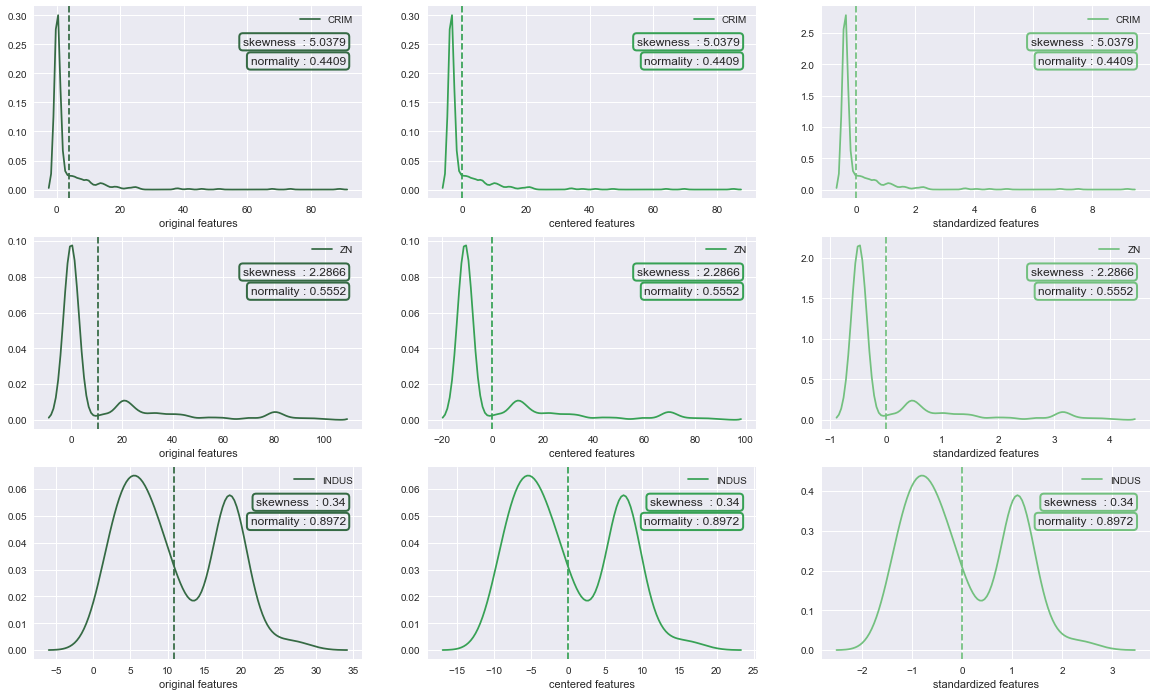

In [10]:
plot_list = [
    { 'df' : df_train, 'xlabel' : 'original features',     'legend_loc' : 'best'},
    #{ 'df' : df_sk,    'xlabel' : 'un-skewed features',    'legend_loc' : 'best'},
    { 'df' : df_cnt,   'xlabel' : 'centered features',     'legend_loc' : 'best'},
    { 'df' : df_std,   'xlabel' : 'standardized features', 'legend_loc' : 'best'}
]

visualized_features = included_features[:3]

n_rows = len(visualized_features)
n_cols = len(plot_list)
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(20, 4 * n_rows ))    
pal = sns.color_palette("Greens_d", n_cols)

p = 0
for (pl_index, pl_dict) in enumerate(plot_list):      
    for (f_index,f) in enumerate(visualized_features) :
        ax = axs[f_index][pl_index] 
        subset = pl_dict['df'][f]       
        
        skewness = round(stats.skew(subset),4)
        normality = round(stats.shapiro(subset)[0],4)
        
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        
        ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('skewness  : {0}'.format(skewness)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))
        ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))        
        
        ax.set_xlabel(pl_dict['xlabel'])
        ax.legend(loc = pl_dict['legend_loc'])
    p += 1
        

#plt.tight_layout()
plt.show()


### Impact on the VIF

<br>

In [11]:
vif_list = [
    {'df' : df_train, 'features' : features, 'label' : 'original'},
    {'df' : df_cnt,   'features' : features, 'label' : 'centered'},
    {'df' : df_std,   'features' : features, 'label' : 'standardized'}
]

template = "{0:<20}:{1:>10}" 
   
for vl in vif_list:    
    vif_dict = uc.compute_vif(df = vl['df'], features = vl['features'])
    print('VIF ({0})'.format(vl['label']))
    print()
    for (key, value) in vif_dict.items():
        print(template.format(key, round(value,4)))
    print()
    print()


VIF (original)

CRIM                :    2.0418
ZN                  :    3.0296
INDUS               :   15.5406
CHAS                :    1.1574
NOX                 :   77.0569
RM                  :   74.3479
AGE                 :   21.0854
DIS                 :   15.0748
RAD                 :    15.361
TAX                 :   65.6476
PTRATIO             :   85.5914
B                   :   19.3088
LSTAT               :   11.3059


VIF (centered)

CRIM                :    1.7513
ZN                  :     2.456
INDUS               :    4.3122
CHAS                :    1.0798
NOX                 :    4.4764
RM                  :    1.9463
AGE                 :    2.9617
DIS                 :    4.0246
RAD                 :     7.678
TAX                 :    9.6658
PTRATIO             :    1.8491
B                   :     1.345
LSTAT               :    3.0057


VIF (standardized)

CRIM                :    1.7513
ZN                  :     2.456
INDUS               :    4.3122
CHAS            

In [12]:
linear_list = [
    { 'df' : df_train,     'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'LinearRegression', 
    # 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in linear_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)

#print(results[['note','intercept', 'err_test']])

## Derivation

<br>
From the previous notebooks we know that the coefficients estimates are found by minimizing a so-called objective (or cost) function; here a comparison of this cost function in the context of OLS (residual sum of squares), Rigde and Lasso (penalized sum of squares) :


<br>
<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{OLS}(\hat{\boldsymbol{\beta}}) 
        &= \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}           
    \end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{R}(\hat{\boldsymbol{\beta}})    
        &= 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad \text{subject to } \quad \sum _{i=1}^{p}{\boldsymbol{\beta_j}^2} \leq t
        \newline        
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            + \boldsymbol{k} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
        \newline
        &= 
            \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
            + \boldsymbol{k} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
        \newline
        &= 
            (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})  
            + \boldsymbol{k} \ ( \ \hat{\boldsymbol{\beta}}^{\top}\hat{\boldsymbol{\beta}} \ )
    \end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{L}(\hat{\boldsymbol{\beta}})    
        &= 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad \text{subject to } \quad \sum _{i=1}^{p} \mid \hat{\boldsymbol{\beta}} \mid \leq t
        \newline        
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            + \boldsymbol{k} \sum _{j=1}^{p} \mid {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \mid
        \newline
        &= 
            \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
            + \boldsymbol{k} \sum _{j=1}^{p} \mid {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \mid
    \end{align}
$
</blockquote>

<br>
For any fixed non-negative $ \ k_1 \ $ and $ \ k_2 \ $, we define the naive elastic net cost function :

<br>
$
    \qquad \quad
    \begin{align}
        S_{EN}(\hat{\boldsymbol{\beta}})    
        &= 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad + \quad \boldsymbol{k_2} \ {\lVert \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \rVert}_2^2
            \quad + \quad \boldsymbol{k_1} \ {\lVert \ \boldsymbol{\beta_j} \ \rVert}_1 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad + \quad \boldsymbol{k_2} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
            \quad + \quad \boldsymbol{k_1} \sum _{j=1}^{p} \mid {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \mid
        \newline
        &=
            \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
            \quad \text{subject to} \quad 
            \left[
                (1 - \boldsymbol{\alpha}){\lVert \ \boldsymbol{\beta_j} \ \rVert}_1 
                + \boldsymbol{\alpha} \ {\lVert \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \rVert}_2^2 
            \right] \ \leq \ t
            \qquad \text{where} \ \boldsymbol{\alpha} = \boldsymbol{k_2} \ / \ (\boldsymbol{k_1} + \boldsymbol{k_2})
            \quad \text{is the elastic net penalty}
    \end{align}
$

<br>
<b>The elastic net penalty $ \ \boldsymbol{\alpha} \ $ is a convex combination of the ridge and lasso penalty </b>:

<br>
<ul style="list-style-type:square">
    <li>
        for $ \ \alpha = 0 \ $
        $ 
            \qquad \Rightarrow \qquad 
            S_{EN}(\hat{\boldsymbol{\beta}}) = S_{OLS}(\hat{\boldsymbol{\beta}}) \quad \text{subject to} \quad 
            {\lVert \ \boldsymbol{\beta_j} \ \rVert}_1 \ \leq \ t  \quad
        $, the naive elastic net becomes lasso regression
    </li>
    <br>
    <li>
         for $ \ \alpha = 1 \ $
        $ 
            \qquad \Rightarrow \qquad 
            S_{EN}(\hat{\boldsymbol{\beta}}) = S_{OLS}(\hat{\boldsymbol{\beta}}) \quad \text{subject to} \quad 
            {\lVert \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \rVert}_2^2  \ \leq \ t  \quad
        $, the naive elastic net becomes ridge regression
    </li>
</ul>

<br>
For all $ \ \boldsymbol{\alpha} \in [0, 1[ \ $, the naive elastic net penalty function is singular (without first derivative) at 0 and it is strictly convex for all $ \ \boldsymbol{\alpha} > 0 \ $, thus having the characteristics of both lasso and ridge regression.


### Differentiability and Analytic Form

<br>
We won't have to develop an ad-hoc method to solve the naive elastic net problem; <b>if we can demonstrate that minimizing the cost function above is equivalent to a lasso-type optimization problem, then elastic net also enjoys the computational advantage of the lasso</b>.

<br>
From the notebook dedicated to lasso regression, we know that the main computational algorithms include subgradient methods, least-angle regression for elastic net (LARS-EN), and proximal gradient methods : 

<br>
<ul style="list-style-type:square">
    <li>
        <b>subgradient methods</b> are the natural generalization of traditional methods such as gradient descent and stochastic
        gradient descent to the case in which the objective function is not differentiable at all points
    </li>
    <br>
    <li>
         <b>LARS</b> is a method that is closely tied to lasso models, and in many cases allows them to be fit very efficiently,
         though it may not perform well in all circumstances
    </li>
    <br>
    <li>
        <b>proximal methods</b> have become popular because of their flexibility and performance and are an area of active
        research; the choice of method will depend on the particular lasso variant being used, the data, and the available
        resources. However, proximal methods will generally perform well in most circumstances
    </li>
</ul>


### Transformation

<br>
We can change the naive elastic net problem into an equivalent lasso problem on augmented data. Given $ \ (\boldsymbol{k_1}, \boldsymbol{k_2}) \ $, let's start by defining an artificial data set $ \ (\boldsymbol{X^*}, \boldsymbol{Y^*})\ $ :

<br>
$
    \quad
    \boldsymbol{X^*}_{(N + p) \ x \ p} 
    = 
        (1 + \boldsymbol{k_2})^{- 1 \ / \ 2} \
        \begin{bmatrix}
            \mathbf{X} \\
            \sqrt{ \boldsymbol{k_2} } \ \mathbf{I}
        \end{bmatrix}
    \qquad \quad
    \boldsymbol{Y^*}_{(N + p)} = \begin{bmatrix} \mathbf{Y} \\ 0 \end{bmatrix}        
$

<br>
The naive elastic net cost function can then be written in the following form, which shows that the naive elastic net can perform an automatic variable selection in a fashion similar to the lasso :

<br>
$
    \quad
    \begin{align}
        S_{NEN}^*(\hat{\boldsymbol{\beta}}^*)    
        &= 
        \newline
        &= 
            S_{OLS}^*(\hat{\boldsymbol{\beta}}^*) 
            \quad + \quad \boldsymbol{\gamma} \ {\lVert \ {\boldsymbol{\beta_j}}^* \ \rVert}_1 
        \newline
        &= 
            \sum _{i=1}^{N}
            ({\boldsymbol{\mathbf{Y}_i}}^* - {\boldsymbol{\mathbf{X}_i}}^{* \ \top} \hat{\boldsymbol{\beta}}^*)^{2}     
            \quad + \quad \boldsymbol{\gamma} \ {\lVert \ {\boldsymbol{\beta_j}}^* \ \rVert}_1 
            \qquad \text{where} \ \boldsymbol{\gamma} = \boldsymbol{k_1} \ / \ \left( \sqrt{1 + \boldsymbol{k_2}} \right)
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad
            & [\textbf{E1}] 
    \end{align}
$


### Solution

<br>
The formulation in <b>E1</b> says that we can transform the naive elastic net problem into an equivalent lasso problem on augmented data. It's also possible to demonstrate that the original coefficients are a scaled version of those derived from the artifical problem :

<br>
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}^* 
        &=  { \rm {arg}}\min _{{\hat{\beta}}^*} S_{NEN}^*(\hat{\boldsymbol{\beta}}^*) 
            \qquad \Rightarrow \qquad 
            \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}
            = \dfrac {1} { \sqrt{1 + \boldsymbol{k_2}} } \ \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}^*
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            & [\textbf{E2}] 
    \end{align}
$

<br>
<b>Note</b> : the sample size in the augmented data set is $ \ (n + p) \ $ and the regressor matrix $ \ \mathbf{X} \ $ has rank $ \ p \ $, which means that <b>the naive elastic net can potentially select all $ \ p \ $ predictors in all situations</b>; this important property overcomes the limitations of the lasso that described in the first scenario.


## Geometric interpretation

<br>
Constrained estimators force the coefficients vector to lie in a geometric shape centered around the origin; the shape of the constrain region is defined by the type of norm we use as penalty. The most commonly used norms are the p-norms, which have the following character :

<br>
$
    \quad
    {\lVert \ \hat{\boldsymbol{\beta}} \ \rVert}_P
    = \left( \ \sum _{j=1}^{p} {\mid \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \mid}^{1/P} \ \right)
    \qquad \text{where} \ P \ \text{defines the P-norm, while} \ p \ \text{(as usual) is the number of features}
$

<br>
In the case of Ridge the constrain region is an n-sphere : the points on the boundary for which some of the components of the coefficients vector are zero are not distinguished from the others. In the picture below we can see that a convex object that lies tangent to the boundary (such as the regression contour) is no more likely to contact a point at which some components of coefficients vector are zero than one for which none of them are.

<br>
In Lasso the constrain region is now a hypercube : the contour is likely to encounter a corner (or in higher dimensions an edge or higher-dimensional equivalent) of the hypercube, for which some components of the coefficients vector are identically zero.

<br>
The constrain region in Elastic Net is a compromise between the two regions described above; <b>we can imagine bending the boundary curve towards either the circle or the rhombus by tuning the ratio of the two hyperparameters involved</b>.


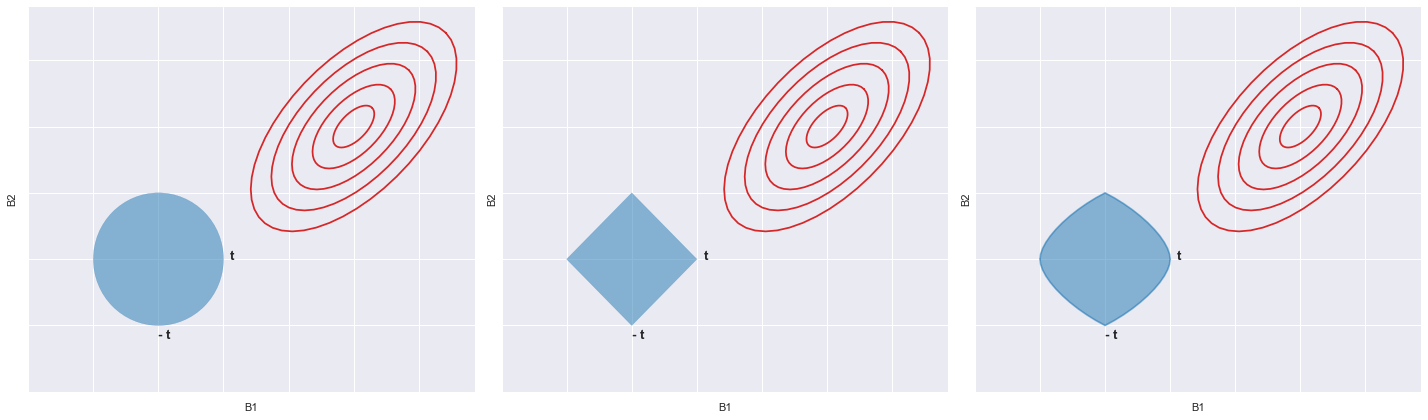

In [13]:
rr.plot_constrain_regions(cmd = 'plot_constrain_regions_ridge_vs_lasso_vs_elastic_net')

## Naive Elastic Net Estimator

<br>
<b>In the case of an orthogonal design matrix</b>, it is straightforward to show that with parameters $ \ (\boldsymbol{k_1}, \boldsymbol{k_2}) \ $ the naive elastic net solution is

<br>
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{NEN \ j}
        &= \dfrac 
            { \left( \mid \hat{\boldsymbol{\beta}}_\boldsymbol{OLS \ j} \mid - \ \boldsymbol{k_1} / 2 \right)_{+} } 
            {1 + \boldsymbol{k_2}}
            \ sign \left( \hat{\boldsymbol{\beta}}_\boldsymbol{OLS \ j} \right) \qquad             
            \text{where} \ z_+ \ \text{denotes the positive part, which is} \ z \ \text{if} \ z > 0 \ \text{and 0 otherwise}
            \qquad \qquad
            & [\textbf{E3}] 
        \newline \newline
        & \Rightarrow
            \begin{cases}
                \hat{\boldsymbol{\beta}}_\boldsymbol{R \ j} \quad = \quad 
                \dfrac { \hat{\boldsymbol{\beta}}_\boldsymbol{OLS \ j} } { 1 + \boldsymbol{k_2} }                 
                \qquad & \text{is the solution of ridge regression with parameter} \ \boldsymbol{k_2}
            \\ \\
                \hat{\boldsymbol{\beta}}_\boldsymbol{L \ j} \quad = \quad 
                \left( \mid \hat{\boldsymbol{\beta}}_\boldsymbol{OLS \ j} \mid - \ \boldsymbol{k_1} / 2 \right)_{+}
                \ sign \left( \hat{\boldsymbol{\beta}}_\boldsymbol{OLS \ j} \right)                
                \qquad & \text{is the solution of lasso regression with parameter} \ \boldsymbol{k_1}
        \end{cases} 
    \end{align}
$


## The grouping effect

<br>
In the $ \ p \gg n \ $ problems, the "grouped variables" situation is a particularly important concern, which has been addressed many times in the literature. 

<br>
Qualitatively speaking, <b>a regression method exhibits the grouping effect if the regression
coefficients of a group of highly correlated variables tend to be equal (up to a change of sign if negatively correlated)</b>. In particular, in the extreme situation where some variables are exactly identical, the regression method should assign identical coefficients to the identical variables.


<br>
Zou and Hastie considereded the generic penalization method :

<br>
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}} 
        = 
            { \rm {arg}}\min _{\hat{\beta}} S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad + \quad \boldsymbol{k} \ J(\hat{\boldsymbol{\beta}})
            \qquad \quad \text{where} \ J(\cdot) \ \text{is positive-valued for} \ \hat{\boldsymbol{\beta}} \neq 0
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            & [\textbf{E4}] 
    \end{align}
$

<br>
Assume that $ \ \boldsymbol{X_i} = \boldsymbol{X_j} \ $, with $ \ i, j \in \{1, \dots, p \} \ $ :

<br>
<ul style="list-style-type:square">
    <li>
         if $ \ J(\cdot) \ $ is strictly convex, then $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{i} =
         \hat{\boldsymbol{\beta}}_\boldsymbol{j} \quad \forall \boldsymbol{k} > 0 \ $
    </li>
    <br>
    <li>
         if $ \ J(\hat{\boldsymbol{\beta}}) = {\lVert \ \boldsymbol{\beta} \ \rVert}_1 \ $,
         then $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{i} \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \geq 0 \ $
         and $ \ \hat{\boldsymbol{\beta}}^* \ $ is another minimizer of equation <b>E4</b>, where <br><br>
         $
             \quad
             \hat{\boldsymbol{\beta}}^*_\boldsymbol{c} =
             \begin{cases}
                 \hat{\boldsymbol{\beta}}_\boldsymbol{c} 
                 \qquad \quad & \text{if} \ c \neq i \ \text{and} \ c \neq j 
                 \\
                 ( \ \hat{\boldsymbol{\beta}}_\boldsymbol{i} + \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ ) \cdot s 
                 \qquad \quad & \text{if} \ c = i 
                 \\
                 ( \ \hat{\boldsymbol{\beta}}_\boldsymbol{i} + \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ ) \cdot (1 - s)
                 \qquad \quad  & \text{if} \ c = j
             \end{cases}
             \qquad \qquad \qquad \text{for any} \ s \in [0,1]
        $
    </li>
</ul>

<br>
We can see a clear distinction between strictly convex penalty functions and the lasso penalty : <b>strict convexity guarantees the grouping effect in the extreme situation with identical predictors; in contrast, the lasso does not even have a unique solution</b>. The elastic net penalty with $ \ \boldsymbol{k_2} > 0 \ $ is strictly convex, thus enjoying the property of grouping highly correlated regressors.

<br>
More details in the original paper <a href="https://web.stanford.edu/~hastie/Papers/B67.2%20(2005)%20301-320%20Zou%20&%20Hastie.pdf">Regularization and variable selection via the elastic net</a>.


### Deficiency of the Naive Elastic Net

<br>
As an automatic variable selection method, the naive elastic net overcomes the limitations of lasso in the first two scenarios): however, empirical evidence shows that the naive elastic net does not perform satisfactorily unless it is very close to either ridge or lasso regression (this is why it's called "naive").

<br>
In the context of regression prediction, an accurate penalization method achieves good prediction performance through the bias–variance trade-off. Naive Elastic Net is a two-stage procedure: for each fixed $ \ \boldsymbol{k_2} \ $ we first find the ridge regression coefficients, and then we execute the lasso-type shrinkage along the lasso coefficient solution paths. 

<br>
It appears to incur a double amount of shrinkage, which does not help to reduce the variances much and introduces unnecessary extra bias, compared with pure lasso or ridge shrinkage. In the next section of the notebook we will improve the prediction performance of Naive Elastic Net by correcting this double shrinkage.


## Elastic Net Estimator

<br>
Given data $ \ (\mathbf{X}, \mathbf{Y}) \ $, penalty parameters $ \ (\boldsymbol{k_1}, \boldsymbol{k_2}) \ $, and augmented
data $ \ (\boldsymbol{X^*}, \boldsymbol{Y^*})\ $, the objective cost function for naive elastic net and the associated estimator are :

<br>
<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{NEN}^*(\hat{\boldsymbol{\beta}}^*)    
        \quad &= \quad
            \sum _{i=1}^{N}
            ({\boldsymbol{\mathbf{Y}_i}}^* - {\boldsymbol{\mathbf{X}_i}}^{* \ \top} \hat{\boldsymbol{\beta}}^*)^{2}     
            \quad + \quad \boldsymbol{\gamma} \ {\lVert \ {\boldsymbol{\beta_j}}^* \ \rVert}_1 
            \qquad \text{where} \ \boldsymbol{\gamma} = \boldsymbol{k_1} \ / \ \left( \sqrt{1 + \boldsymbol{k_2}} \right)
    \end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}^* 
        \quad &=  \quad { \rm {arg}}\min _{{\hat{\beta}}^*} S_{NEN}^*(\hat{\boldsymbol{\beta}}^*)             
    \end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}
        \quad &= \quad 
        \newline
        &= \quad \dfrac {1} { \sqrt{1 + \boldsymbol{k_2}} } \ \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}^*
        \newline
        &=
            \quad
            \dfrac {1} { \sqrt{1 + \boldsymbol{k_2}} } \ 
            { \rm {arg}}\min _{{\hat{\beta}}^*} S_{NEN}^*(\hat{\boldsymbol{\beta}}^*)     
            \left[ 
                \ \sum _{i=1}^{N}
                ({\boldsymbol{\mathbf{Y}_i}}^* - {\boldsymbol{\mathbf{X}_i}}^{* \ \top} \hat{\boldsymbol{\beta}}^*)^{2}     
                \quad + \quad 
                \dfrac { \boldsymbol{k_1} } { \left( \sqrt{1 + \boldsymbol{k_2}} \right) } 
                \ {\lVert \ {\boldsymbol{\beta_j}}^* \ \rVert}_1 \             
            \right]
    \end{align}
$
</blockquote>


<br>
<b>The (corrected) elastic net  estimator is defined as </b>:

<br>
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{EN}
        &=
        \newline
        &=
            \left( \ \sqrt{1 + \boldsymbol{k_2}} \ \right) \ \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}^* 
        \newline
        &= 
            \left( \ \sqrt{1 + \boldsymbol{k_2}} \ \right) \left( \ \sqrt{1 + \boldsymbol{k_2}} \ \right) \ 
            \hat{\boldsymbol{\beta}}_\boldsymbol{NEN} 
        \newline
        &=
            \left( \ 1 + \boldsymbol{k_2} \ \right) \
            \hat{\boldsymbol{\beta}}_\boldsymbol{NEN}           
    \end{align}
$

<br>
The <b>Elastic Net</b> estimator <b>is a rescaled version of Naive Elastic Net</b>; such a scaling transformation preserves the variable selection property of the naive elastic net and is the simplest way to undo (double) shrinkage.



## Choice of the Regularization Parameter

<br>
We now discuss how to choose the type and value of the tuning parameter in the elastic net; although we initially defined the elastic net by using $ \ ( \boldsymbol{k_1}, \boldsymbol{k_2} ) \ $, this is not the only choice as the tuning parameter.

<br>
By the proportional relationship between $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{EN} \ $ and $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{NEN} \ $, we can also use $ \ ( \boldsymbol{k_2}, s ) \ $ to parameterize the elastic net (where $ \ s \ $ corresponds to the value of $ \ \boldsymbol{k_1} \ $ in terms of a ratio of $ \ \boldsymbol{k_2} \ $); the advantage of using this type of parametrization is that $ \ s \ $ is always valued within [0, 1].

<br>
In the LARS algorithm, lasso is described as a forward stagewise additive fitting procedure; this new interpretation adopts the number of steps of the LARS algorithm as a tuning parameter for the lasso. For each fixed $ \ \boldsymbol{k_2} \ $, the elastic net is solved by the LARS-EN algorithm; hence similarly we can use the number of the LARS-EN steps as the second tuning parameter (beside $ \ \boldsymbol{k_2} \ $).


### Solution Trace

<br>
Unlike ridge and lasso regression, in elastic net there are two hyper-parameters to be tuned, and cross-validation is performed on a two-dimensional surface. 

<br>
Typically, we first pick a (relatively small) grid of values for the ridge paramteer $ \ \boldsymbol{k_2} \ $, (e.g. [0, 0.01, 0.1, 1, 10, 100] ); then, for each $ \ \boldsymbol{k_2} \ $, the LARS-EN algorithm produces the entire solution path of the elastic net. The other tuning parameter ($ \ \boldsymbol{k_1} \ $, or $ \ s \ $) is selected by CV.

<br>
In the case of elastic net, coming to an idea of the estimates behaviour just by looking at the solution trace it's much harder than it has been for ridge and lasso. 


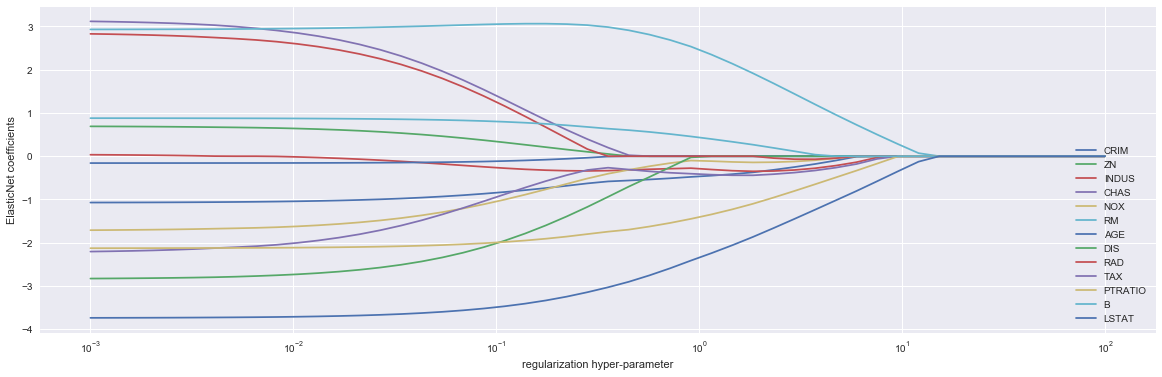

In [14]:
n_alphas = 50
alphas = np.logspace(-3, 2, n_alphas)

# the default value for l1_ratio=0.5

rr.plot_coefficients(
    df = df_std, 
    features = features, 
    target = target, 
    linear_model_name = 'ElasticNet', 
    linear_model_args = {'fit_intercept' :True}, 
    alphas = alphas
)



### Variance Inflation Factor

<br>

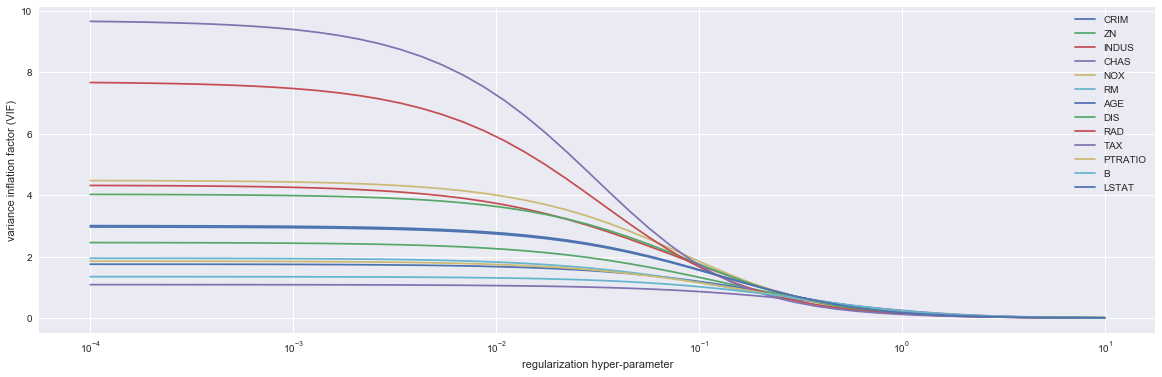

In [15]:
n_alphas = 50
alphas = np.logspace(-4, 1, n_alphas)

rr.plot_vif(df = df_std, features = features, alphas = alphas)

### Grid-Search Cross Validation

<br>

In [16]:
l1_ratio_brackets = (
    np.linspace(0.01, 0.1, 10),   # more values towards l1_ratio = 0 (pure ridge regression)
    np.linspace(0.11, 0.9, 20), 
    np.linspace(0.91, 1, 10)      # more values towards l1_ratio = 1 (pure lasso regression)
    )
l1_ratio = np.concatenate(l1_ratio_brackets)
    
n_alphas = 20
alphas = np.logspace(-1, 1, n_alphas)


scoring_list = {
    'MSE' : 'neg_mean_squared_error', 
    'R2' : 'r2'}

#grid = GridSearchCV(
#    estimator = lm.ElasticNet(fit_intercept = True), 
#    #param_grid = { 'l1_ratio' : l1_ratio, 'alpha' : alphas },
#    param_grid = { 'l1_ratio' : l1_ratio },
#    scoring = scoring_list,  
#    refit = 'MSE',
#    cv = 10
#)

#grid.fit(df_std[features], df_std[target])
#grid_results = grid.cv_results_

model = lm.ElasticNetCV(
    l1_ratio = l1_ratio, 
    alphas = alphas,
    fit_intercept=True,
    cv = 10
)

model.fit(df_std[features].as_matrix(), df_std[target])
mse_path = model.mse_path_


In [17]:
mse_path_array = np.empty(shape = [len(l1_ratio)*len(alphas),3], dtype = float)

l1_ratio_cnt = 0
for outer_list in mse_path :
    alphas_cnt = 0
    for inner_list in outer_list:
        index = l1_ratio_cnt*(n_alphas**1) + (alphas_cnt)*(10**0)
        values = np.array( [l1_ratio[l1_ratio_cnt], alphas[alphas_cnt], np.mean(inner_list)] )
        mse_path_array[index] = values        
        alphas_cnt += 1
    l1_ratio_cnt += 1

print(mse_path_array.shape)    


(800, 3)


In [18]:
mse_path_df = pd.DataFrame(data = mse_path_array, columns = ['l1_ratio', 'alpha', 'mse'])
mse_path_df_pivot = pd.pivot_table(data = mse_path_df, index = 'alpha', columns = 'l1_ratio', values = 'mse')


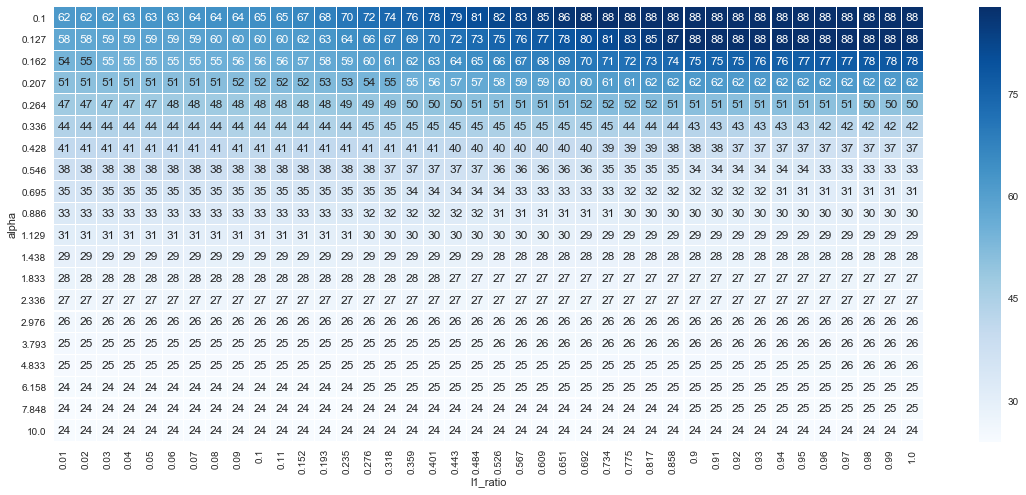

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 8))    
sns.heatmap(data = mse_path_df_pivot, cmap = "Blues", annot = True, 
            linewidths = 0.1, linecolor = 'white', 
            cbar = True, square = True, 
            xticklabels = np.around(a = l1_ratio, decimals = 3), 
            yticklabels = np.around(a = alphas, decimals = 3),
            ax = ax)
plt.show()

In [20]:
l1_ratio = 0.5
alpha = 10**(0)

en_list = [
    { 'df' : df_train,     'linear_model_name' : 'ElasticNet', 
     'linear_model_args' : {'l1_ratio' : l1_ratio, 'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'original' },
    { 'df' : df_cnt, 'linear_model_name' : 'ElasticNet', 
     'linear_model_args' : {'l1_ratio' : l1_ratio, 'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'ElasticNet', 
     'linear_model_args' : {'l1_ratio' : l1_ratio, 'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'standardized'}    
]

results_en = pd.DataFrame()

for l in en_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results_en = results_en.append(results_temp).reset_index(drop = True)

#print(results_lasso[['note','intercept', 'err_test']])

## Impact on the intercept

<br>

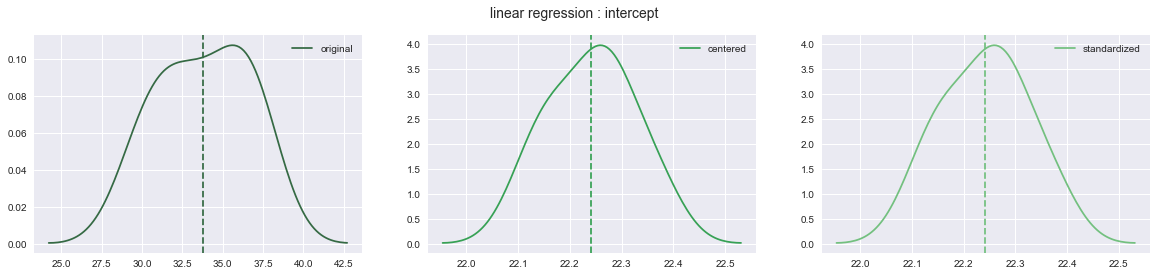

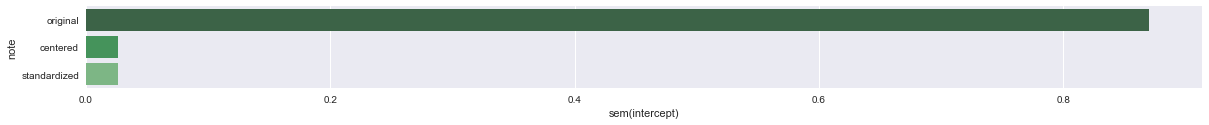

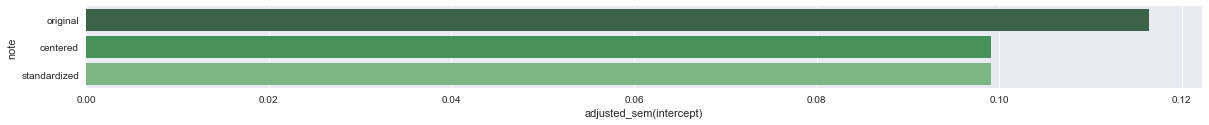

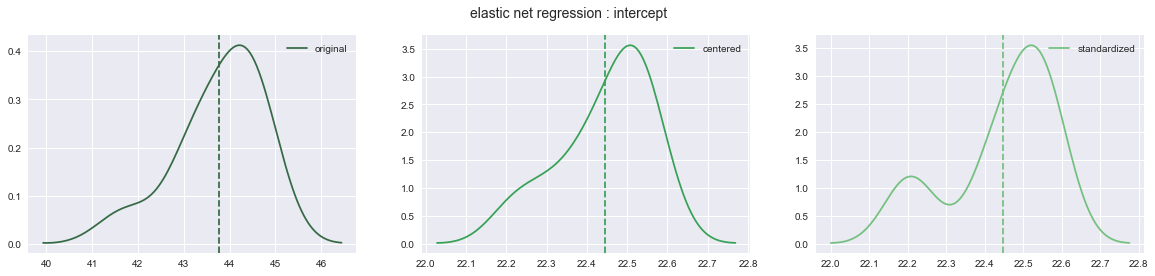

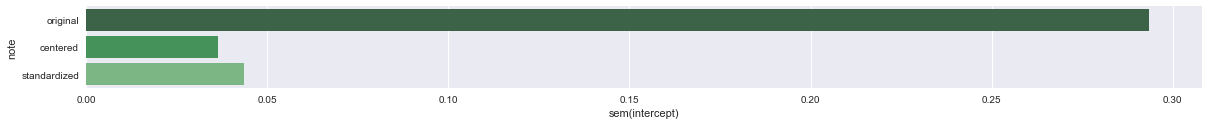

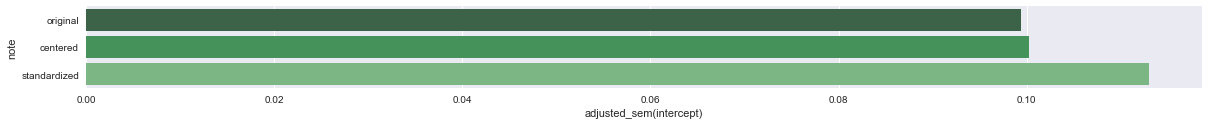

In [21]:
up.plot_across_discriminant(
    df = results, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

up.plot_across_discriminant(
    df = results_en, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'elastic net regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

## Impact on the regression coefficients of the transformed features

<br>

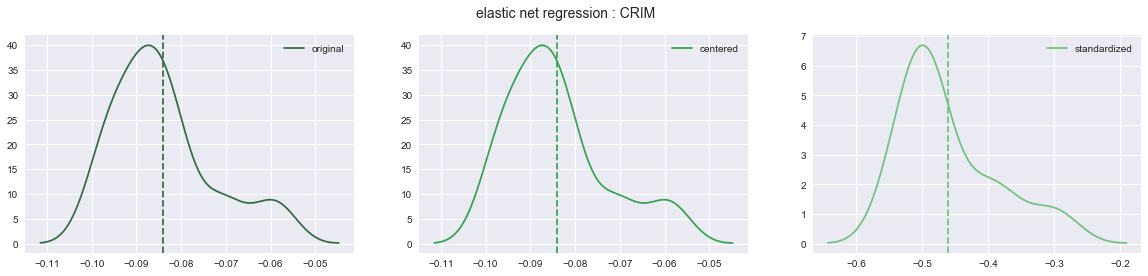

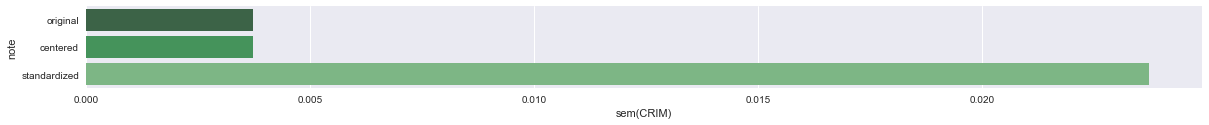

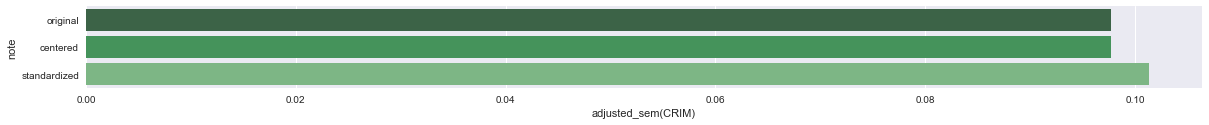

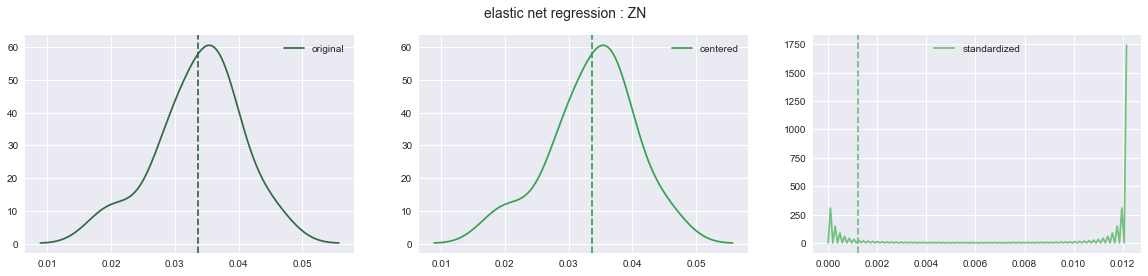

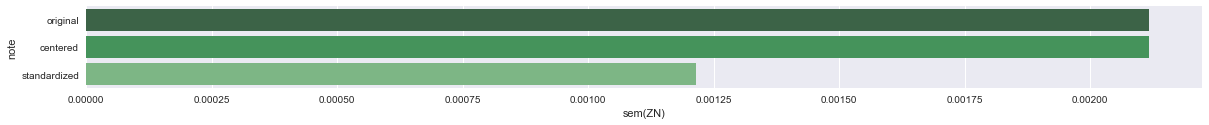

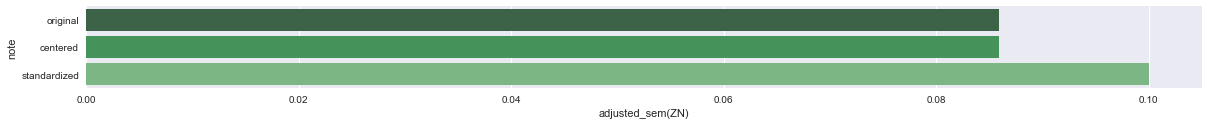

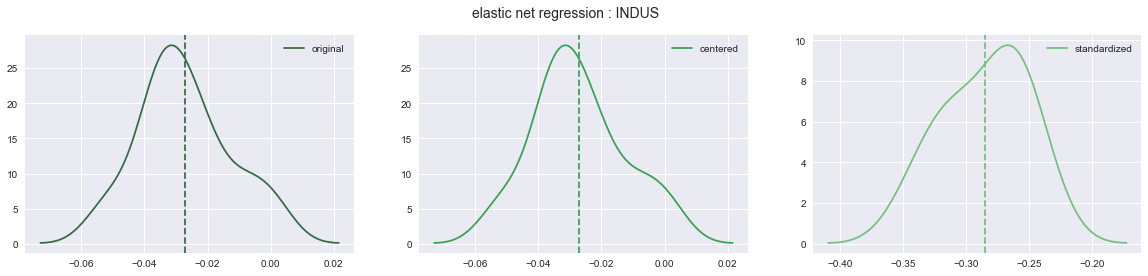

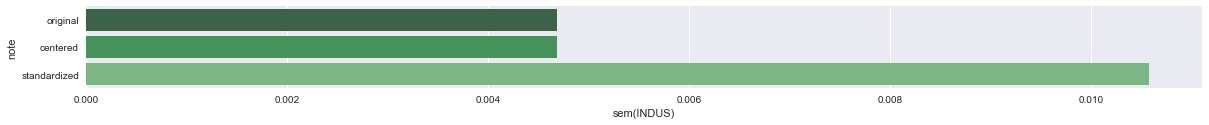

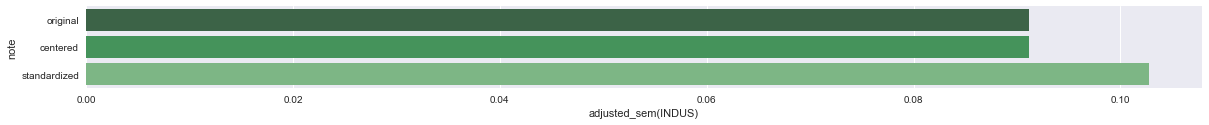

In [22]:
visualized_features = included_features[:3]

up.plot_across_discriminant(
    df = results_en, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'elastic net regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)    
    

## Impact on the regression coefficients of the non-transformed features

<br>

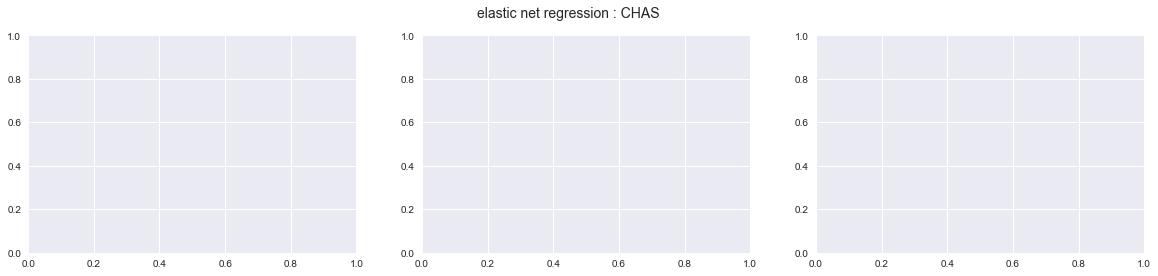

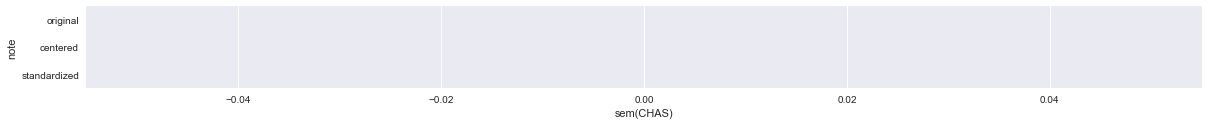

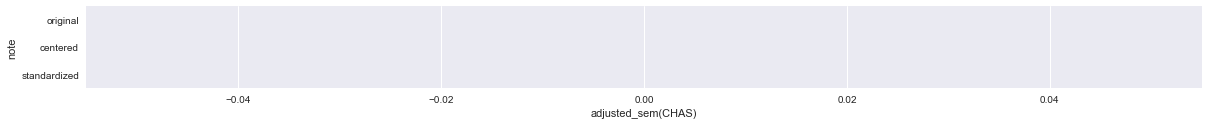

In [23]:
visualized_features = excluded_features

up.plot_across_discriminant(
    df = results_en, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'elastic net regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

    

## Impact on the regression score

<br>

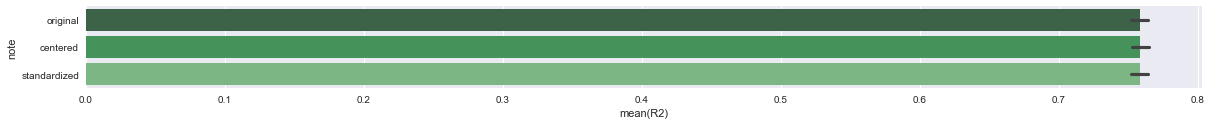

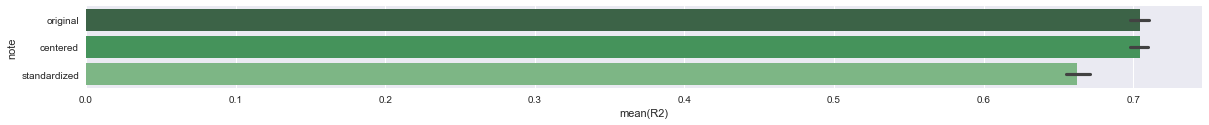

                                            linear regression                                           elastic net regression

R2 mean (original)       :                             0.7581     R2 mean (original)       :                            0.7042
R2 mean (centered)       :                             0.7581     R2 mean (centered)       :                            0.7042
R2 mean (standardized)   :                             0.7581     R2 mean (standardized)   :                            0.6627


In [24]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)

up.plot_across_discriminant(
    df = results_en, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'elastic net regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


template = "{0:>61}{1:>65}" 
print(template.format('linear regression', 'elastic net regression'))
print()

discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}     {2:25}:{3:34}" 
for (d_index,d) in enumerate(discriminant_values):
    label_1 = ('{0} mean ({1})'.format(metric, d))
    label_2 = ('{0} mean ({1})'.format(metric, d))
    
    criteria = (results_en['note'] == d)
    
    subset_1 = results[criteria][metric]    
    subset_2 = results_en[criteria][metric]
    
    print(template.format(label_1, round(subset_1.mean(), 4), label_2, round(subset_2.mean(), 4)))


## Considerations

<br>
In this notebook we have introduced the <b>Elastic Net</b>, a new estimator which <b>overcomes the limitations of Ridge and Lasso regression while retaining both shrinkage and features selection</b>. Elastic Net produces a sparse model with good prediction accuracy <b>and is able to group highly correlated regressors</b>. 

<b>Elastic Net should always be considered as a better alternative to pure ridge or lasso regression, because it solves the limitations of both methods, while also including each as special cases</b> : if ridge (or lasso) is eventually found to be the best estimator, then any good model selection routine will identify that as part of the modeling process from the Elastic Net.



## References

<br>
<ul style="list-style-type:square">
    <li>
         Stanford University - Zou and Hastie - 
         <a href="https://stanford.io/1OWWTyZ">
         Regularization and Variable Selection via the Elastic Net</a>        
    </li>
    <br>
    <li>
         Alex Lenail - 
         <a href="https://bit.ly/2soJpu9">
         What is the difference between Ridge Regression, the LASSO, and ElasticNet?</a>        
    </li>
    <br>
    <li>
        StackExchange - Cross Validated - 
        <a href="https://bit.ly/2Jgcwdf">
        What is elastic net regularization, and how does it solve the drawbacks of Ridge (L2) and Lasso (L1) ?</a>               
    </li>
</ul>